# CNN

## Utilisation de Jupyter Notebook

Le principe est simple : 
 - Chaque notebook est constitué d’une liste de **cellules**
 - Chacune peut contenir du **texte formaté** ou du **code** (Python, dans notre cas)
 - On **exécute** une cellule de code -> le résultat s’affiche sous la cellule

Cliquez sur le menu **Help** > **User Interface Tour** pour un tour rapide de l’interface.    

Pour vous entraîner :
- **Insérez** quelques cellules de code au début du notebook
- Exécutez quelques commandes Python, telles que **print("Hello world!")** :
    - Cliquez dans une cellule de code et saisissez le code à exécuter
    - Exécutez le code de la cellule en tapant Shift-Entrée ou en cliquant sur le bouton d’exécution
    
Lorsque vous **cliquez** à l’intérieur d’une cellule, vous passez en mode **édition** (la cellule est alors encadrée en *vert*). Lorsque vous tapez la **touche Echap** (Esc) ou que vous cliquez juste à gauche de la cellule, vous passez en mode **commande** (la cellule est alors encadrée en *bleu*). 

Lorsque vous êtes en **mode commande**, tapez la **touche H** pour afficher les nombreux **raccourcis clavier** disponibles

## Préparation

Tout d'abord, assurons-nous que ce bloc-notes fonctionne bien en python 3, importons quelques modules communs, assurons-nous que MatplotLib trace des figures :

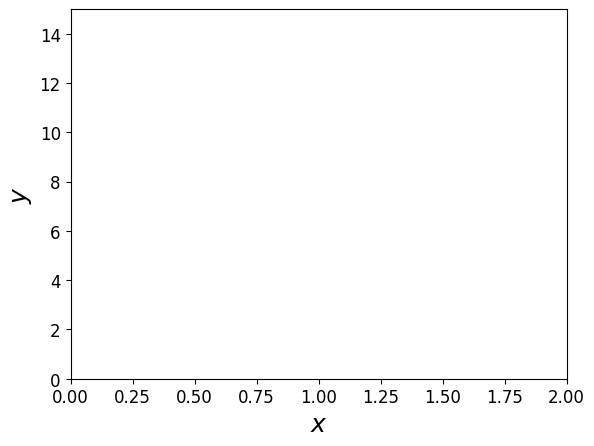

In [1]:
# Pour soutenir à la fois python 2 et python 3
from __future__ import division, print_function, unicode_literals

# Importations communes
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# Pour que la production soit stable d'un bout à l'autre
np.random.seed(42)

# Pour tracer de jolis figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=90, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

Quelques fonctions pour afficher des images à niveaux de gris ou en couleur :

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

def crop(images):
    return images[150:220, 130:250]

Pour utiliser TensorFlow :

In [3]:
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Pour utiliser d'autres utilitaires :

In [4]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# La couche de convolution

Le code ci-dessous permet d'appliquer un **filtre de convolution** *vertical* et *horizontal* sur une image exemple :

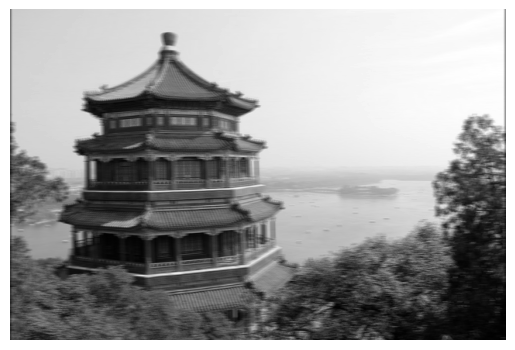

In [5]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

L'image originale peut être affichée comme ci-dessous :

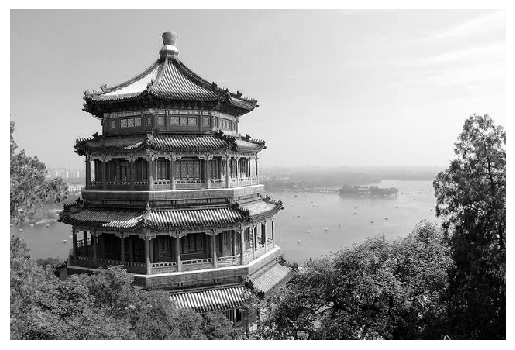

In [6]:
plot_image(images[0, :, :, 0])
plt.show()

L'application du filtre vertical donne ceci :

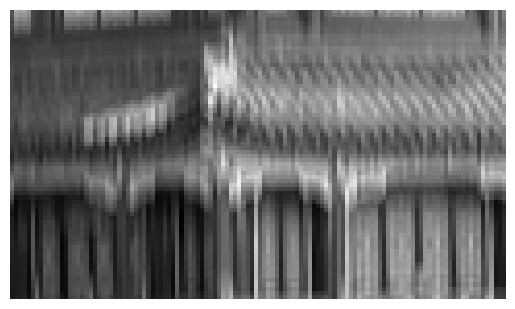

In [7]:
plot_image(crop(outputs[0, :, :,0]))
plt.show()

L'application du filtre horizontal donne ceci :

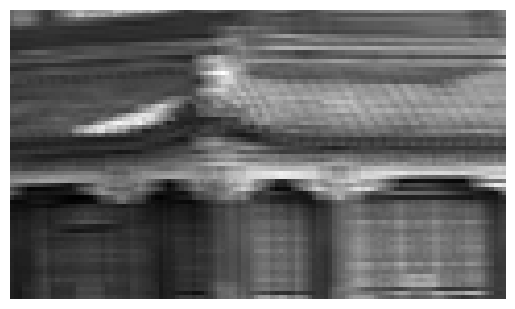

In [8]:
plot_image(crop(outputs[0, :, :,1]))
plt.show()

**Question 1.1 :** Afficher dessous votre propre image et le résultat du filtre horizontal. 

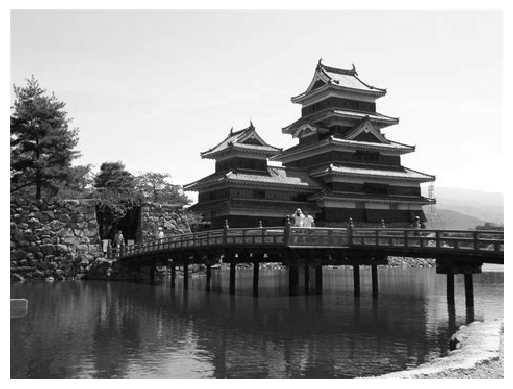

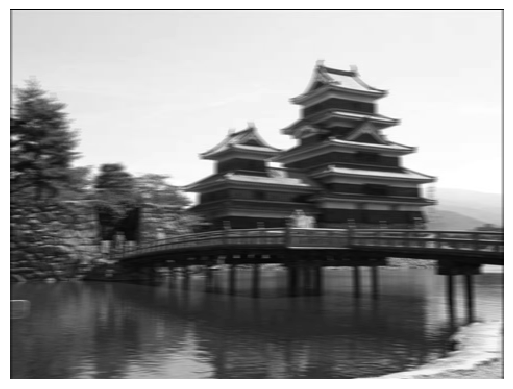

In [9]:
# Reponse
from PIL import Image

img = np.array(Image.open('monImage.jpg'))
height, width, channels = img.shape
image_grayscale = img.mean(axis=2).astype(np.float32)
monImages = image_grayscale.reshape(1, height, width, 1)
plot_image(monImages[0, :, :, 0])
plt.show()
filters = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
filters[2, :, :, 1] = 1  # horizontal line
outputs = tf.nn.conv2d(monImages, filters, strides=1, padding="SAME")

plot_image(outputs[0, :, :, 1])
plt.show()


**Question 1.2 :** Quelle partie de l'image ce filtre met-il en évidence ?

Le filtre horizontal met en evidence les lignes horizontales de l'image

Le code ci-dessous applique les **2** filtres sur la même image :

In [10]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

In [11]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [12]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [13]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [14]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

Image de départ :

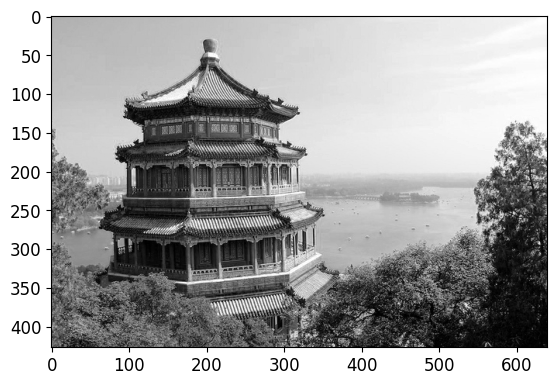

In [15]:
plt.imshow(images[0, :, :, 0], cmap="gray")

Image résultante :

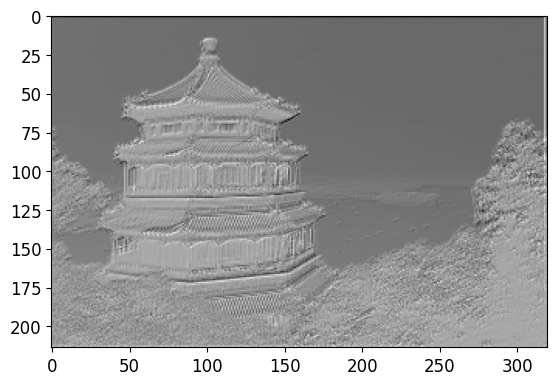

In [16]:
same_output[0, :, :,0].shape
plt.imshow(same_output [0, :, :, 0], cmap="gray") # plot 1st image's 2nd feature map
#plt.show()

**Question 1.3** Faire la même chose avec une image à vous

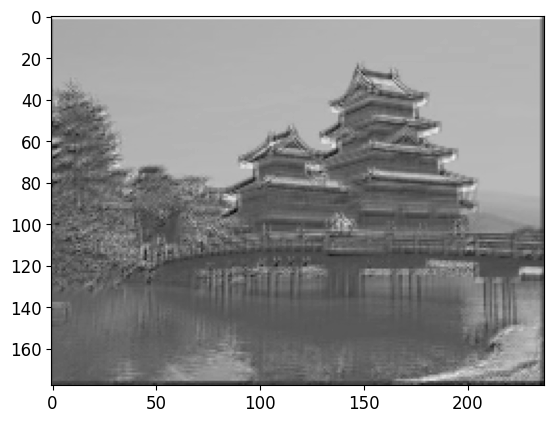

In [17]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(monImages, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(monImages.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(monImages.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())
same_output[0, :, :,0].shape
plt.imshow(same_output [0, :, :, 0], cmap="gray") # plot 1st image's 2nd feature map

**Question 1.4** : Que représente ce résultat, qu'est-ce qui est mis en valeur ?

Avec ce filtre on met en valeur les contours de l'image

# Couche de pooling

Le code ci-dessous permet d'extraire une couche de **pooling** ([doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) d'une image :

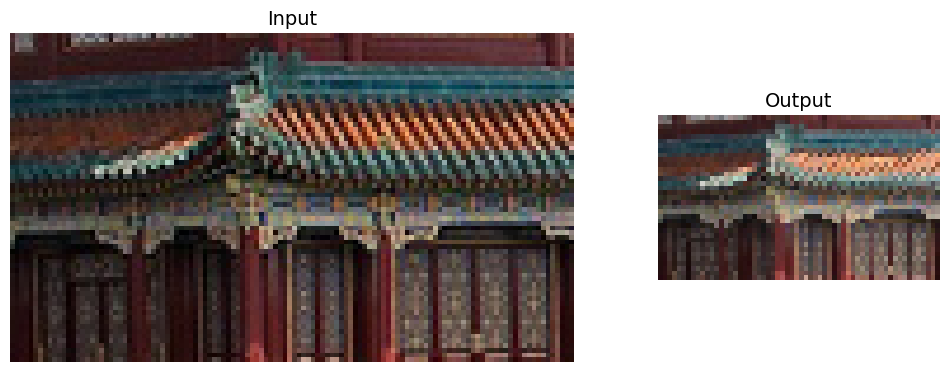

In [18]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

**Question 2.1 :** Modifier le code ci-dessous pour faire une couche de pooling de taille 8x8.

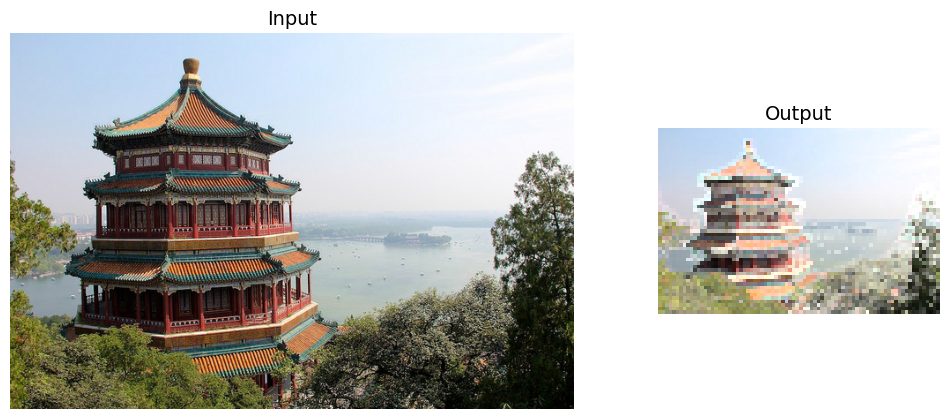

In [19]:
max_pool = keras.layers.MaxPool2D(pool_size=8)
my_images = np.array([image for image in images], dtype=np.float32)
output = max_pool(my_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

**Question 2.2 :** Est-ce qu'il y a de la perte d'information ? Cela va-t-il favoriser le surajustement ?

Oui il y a une perte d'information et cela va favoriser le surajustement

**Question 2.3 :** Modifier le code ci-dessous pour faire pour créer une couche de mean-pooling qui utilise la moyenne plutôt que le maximum

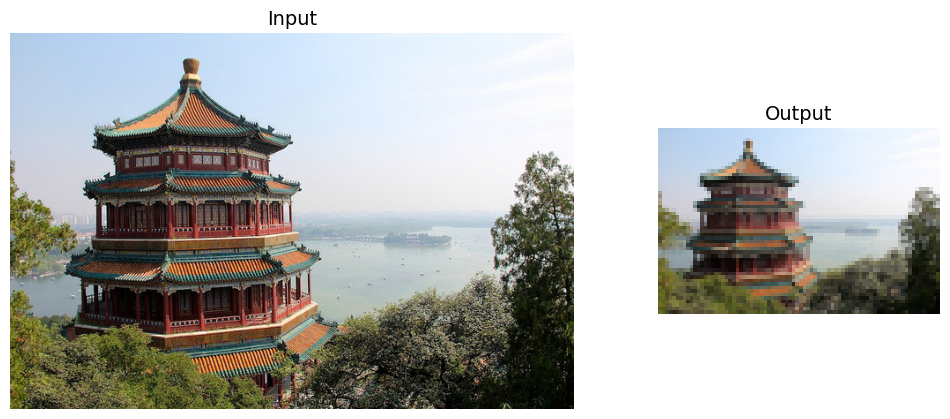

In [20]:
max_pool = keras.layers.AvgPool2D(pool_size=8)
my_images = np.array([image for image in images], dtype=np.float32)
output = max_pool(my_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

**Question 2.4** Est-ce que l'image est plus clair ou plus sombre qu'avec le maximum ? Expliquer pourquoi

L'image est plus sombre car on prend la moyenne des pixels et que cette image a bcp de contraste et de blanc

# Utilisation de CNN

Le fichier [model](model.h5) contient les poids d'un réseau CNN appris à l'aide de la base disponible [ici](https://www.kaggle.com/c/dogs-vs-cats/data) et du programme [learnCat.py](learnCat.py)

![](https://miro.medium.com/max/3840/1*oB3S5yHHhvougJkPXuc8og.gif)

Pour charger le modèle, utiliser : 

In [21]:
# Keras - high-level API for TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator



###########################
#  Définition du CNN      #
###########################

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))


###################################
#  Chargement des poids entraînés #
###################################

model.load_weights('model.h5');

In [22]:
def predict_class(fichier):
    #import image
    image=plt.imread(fichier)
    plot_image(image)
    #preprocess image
    image=np.array(image)
    image=image.astype("float32")/255
    #predict
    img_size = 150
    inference=model.predict((tf.expand_dims(tf.image.resize(image,(img_size,img_size)),axis=0)))
    predicted_class_indices = np.round(inference)
    return (predicted_class_indices)

Pour tester, une image :

1/1 [==============================] - 0s 380ms/step
dog
1/1 [==============================] - 0s 52ms/step
cat
1/1 [==============================] - 0s 29ms/step
cat
1/1 [==============================] - 0s 40ms/step
cat
1/1 [==============================] - 0s 46ms/step
dog
1/1 [==============================] - 0s 42ms/step
dog
1/1 [==============================] - 0s 48ms/step
cat


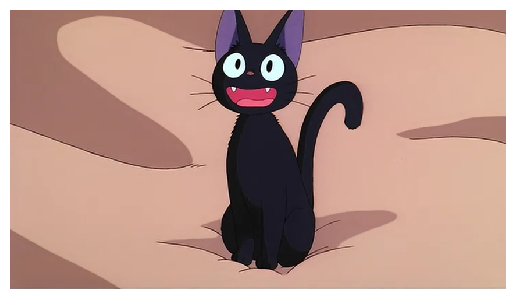

In [23]:
def toText(c):
    if c[0][0] == 1:
        return "dog"
    else :
        return "cat"
print(toText(predict_class("dog.jpg")))
print(toText(predict_class("cat.jpg")))
print(toText(predict_class("weirdCat.jpg")))
print(toText(predict_class("hidingCat.jpg")))
print(toText(predict_class("redPanda.jpg")))
print(toText(predict_class("chi.jpg")))
print(toText(predict_class("kuroneko.jpg")))

**Question 3** Faire des expériences avec plusieurs images d'internet et faire en compte rendu ci-dessous


Le model est capable de reconnaitre les chats et les chiens mais il a du mal avec les images de chats et de chiens qui ne sont pas des photos

# Préparation de la SAé

### 1 - Base d'apprentissage

1. Faire une vidéo de chaque figurine de plusieurs minutes

- Le fond doit être exactement le même pour les deux figurines
- Eviter de mettre le même fond que les autres étudiants

2. Convertir la video en images, par exemple avec (ffmpeg)[https://ffmpeg.org] :

```ffmpeg -i obelix.MOV -r 10    -vf scale=150:150 obelix/obelix%03d.jpg```

avec :
   - ``obelix.MOV`` : le fichier video
   - ``10`` : la fréquence pour récupérer une image
   - ``150:150``la taille de l'image
   - ``obelix/obelix%03d.jpg``la forme du fichier image en sortie

![](https://gitlab.inria.fr/Seshat/deepAsterix/-/raw/master/images/dossiers.jpg)

La vidéo doit comprendre des rotations et translations.

3. Ajouter d'autres images trouvées sur internet (bande dessinée, images 3D, films, costumes, etc.) ou généré à partir de webGL avec [https://members.loria.fr/PFVillard/files/asterix/asterix.html](https://members.loria.fr/PFVillard/files/asterix/asterix.html)


4. Faire un dossier pour **Obelix** et un dossier pour **Asterix**

**Question 4.1** Afficher 20 exemples d'images assez différentes pour Asterix et Obelix sous forme de tableau

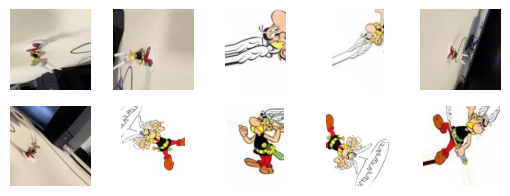

In [24]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def loadImages(path):
    imagesList = os.listdir(path)
    loadedImages = []
    for image in imagesList:
        img = Image.open(path + image)
        loadedImages.append(img)

    return loadedImages

path = "./Asterix/"
# your images in an array
imgsAsterix = loadImages(path)
random.shuffle(imgsAsterix)

# plot 10 images
i = 1
for img in  imgsAsterix[:10]:
    plt.subplot(4,5,i)
    plt.imshow(img)
    plt.axis('off')
    i += 1


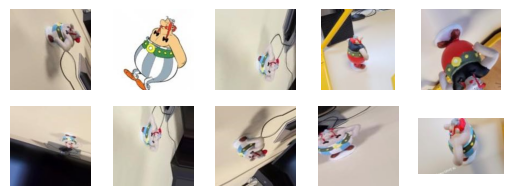

In [25]:
# same for ./Obelix
path = "./Obelix/"
# your images in an array
imgsObelix = loadImages(path)
random.shuffle(imgsObelix)


# plot 10 images
i = 1
for img in  imgsObelix[:10] :
    plt.subplot(4,5,i)
    plt.imshow(img)
    plt.axis('off')
    i += 1

### 2 - Architecture du réseau de neurone et apprentissage

En s'inspirant de l'exercice avec les chats et les chiens :
1. Implémenter une architecture pour détecter automatiquement si une image représente Asterix ou Obelix
   - charger les images en divisant **données d'entraineemnt** et **données d'apprentissage**. Pour plus d'information sur la méthode `image_dataset_from_directory`, voir la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)
   - utiliser une architecture du type CNN
2. Effectuer l'apprentissage en essayant plusieurs hyperparamètres
3. Enregistrer le modèle appris au format `h5`

**Question 4.2** Mettre le code correspondant aux questions ci-dessus.

In [26]:
from PIL import Image
def loadImages(path):
    imagesList = os.listdir(path)
    loadedImages = []
    for image in imagesList:
        # if the image is not in RGB format, convert it
        img = Image.open(path + image)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        loadedImages.append(img)

    return loadedImages


In [27]:
augment = False

In [28]:
import random
import os
import numpy as np
import tensorflow as tf
# create directories if they don't exist
if not os.path.exists('./data'):
    os.mkdir('./data')
if not os.path.exists('./data/train'):
    os.mkdir('./data/train')
if not os.path.exists('./data/validation'):
    os.mkdir('./data/validation')
if not os.path.exists('./data/train/Asterix'):
    os.mkdir('./data/train/Asterix')
if not os.path.exists('./data/train/Obelix'):
    os.mkdir('./data/train/Obelix')
if not os.path.exists('./data/validation/Asterix'):
    os.mkdir('./data/validation/Asterix')
if not os.path.exists('./data/validation/Obelix'):
    os.mkdir('./data/validation/Obelix')
imgsAsterix = loadImages("./Asterix/")
imgsObelix = loadImages("./Obelix/")
if augment:
    # use keras to make data augmentation
    from keras.preprocessing.image import ImageDataGenerator, img_to_array
    datagen = ImageDataGenerator(
            rotation_range=360,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest')

    # augment data
    for img in imgsAsterix:
        try :
            if "augmented" in img.filename:
                break # all images are already been modified
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            i = 0
            for batch in datagen.flow(x, batch_size=1,
                                    save_to_dir='./Asterix/', save_prefix='augmented', save_format='jpg'):
                i += 1
                if i > 20:
                    break  # otherwise the generator would loop indefinitely
        except:
            print("error")
    imgsAsterix = loadImages("./Asterix/")

    for img in imgsObelix:
        if "augmented" in img.filename:
            break # all images are already been modified
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        i = 0
        for batch in datagen.flow(x, batch_size=1,
                                save_to_dir='./Obelix/', save_prefix='augmented', save_format='jpg'):
            i += 1
            if i > 20:
                break  # otherwise the generator would loop indefinitely

    imgsObelix = loadImages("./Obelix/")
random.shuffle(imgsAsterix)
random.shuffle(imgsObelix)
# if ./data/train/Asterix is empty , fill it with 80% of imgsAsterix
if not os.listdir('./data/train/Asterix'):
    # take 80% of asterixIndex
    for i in range(int(len(imgsAsterix)*0.8)):
        imgsAsterix[i].save('./data/train/Asterix/'+str(i)+'.jpg')
print("There is " + str(len(imgsAsterix)) + " images of Asterix")
# if ./data/train/Obelix is empty , fill it with 80% of imgsObelix
if not os.listdir('./data/train/Obelix'):
    # take 80% of obelixIndex
    for i in range(int(len(imgsObelix)*0.8)):
        imgsObelix[i].save('./data/train/Obelix/'+str(i)+'.jpg')
print("There is " + str(len(imgsObelix)) + " images of Obelix")
# if ./data/validation/Asterix is empty , fill it with 20% of imgsAsterix
if not os.listdir('./data/validation/Asterix'):
    for i in range(int(len(imgsAsterix)*0.8),len(imgsAsterix)):
        imgsAsterix[i].save('./data/validation/Asterix/'+str(i)+'.jpg')
# if ./data/validation/Obelix is empty , fill it with 20% of imgsObelix
if not os.listdir('./data/validation/Obelix'):
    for i in range(int(len(imgsObelix)*0.8),len(imgsObelix)):
        imgsObelix[i].save('./data/validation/Obelix/'+str(i)+'.jpg')

There is 896 images of Asterix
There is 924 images of Obelix


**Question 4.3** Mettre toutes les courbes d'apprentissages issues de tous vos entraînement, par exemple, sous forme d'images. 

In [22]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        #strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
        #print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

[]


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a dataset using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './data/train',
    labels="inferred",
    label_mode="int", # categorical, binary
    class_names=["Asterix","Obelix"],
    color_mode="rgb",
    batch_size=32,
    image_size=(150, 150),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './data/train',
    labels="inferred",
    label_mode="int", # categorical, binary
    class_names=["Asterix","Obelix"],
    color_mode="rgb",
    batch_size=32,
    image_size=(150, 150),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
)


# create model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# start training

model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
)

# save model

model.save_weights('modelAsterixObelix.h5')


Found 1455 files belonging to 2 classes.
Using 1164 files for training.
Found 1455 files belonging to 2 classes.
Using 291 files for validation.
Epoch 1/50
37/37 [==============================] - 11s 265ms/step - loss: 19.6440 - accuracy: 0.5352 - val_loss: 0.6869 - val_accuracy: 0.5945
Epoch 2/50
37/37 [==============================] - 12s 298ms/step - loss: 1.4811 - accuracy: 0.5911 - val_loss: 0.6516 - val_accuracy: 0.6460
Epoch 3/50
37/37 [==============================] - 11s 291ms/step - loss: 0.7860 - accuracy: 0.6426 - val_loss: 0.5713 - val_accuracy: 0.6186
Epoch 4/50
37/37 [==============================] - 12s 310ms/step - loss: 0.7050 - accuracy: 0.6838 - val_loss: 0.5074 - val_accuracy: 0.7766
Epoch 5/50
37/37 [==============================] - 13s 335ms/step - loss: 0.7000 - accuracy: 0.7723 - val_loss: 0.5693 - val_accuracy: 0.7835
Epoch 6/50
37/37 [==============================] - 14s 346ms/step - loss: 0.6816 - accuracy: 0.7766 - val_loss: 0.4941 - val_accuracy: 0.6

Precision sans internet :




 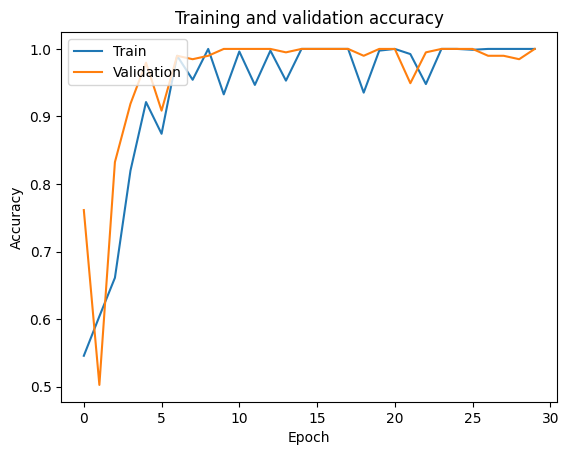

Precision avec internet :



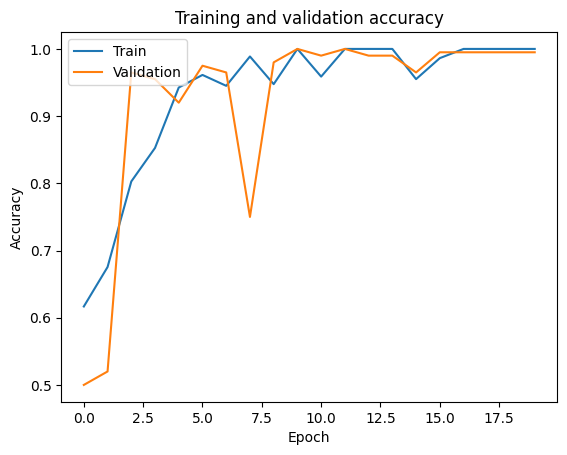

Precision avec des donnée des validation differente et augmentation de donnée: 


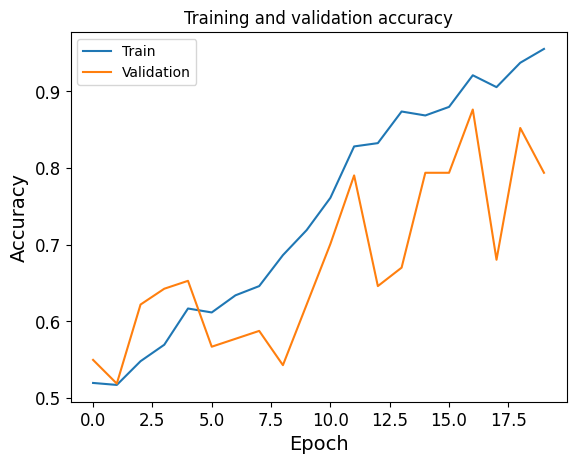


Precision avec des donnée des validation differente et augmentation de donnée , 30 epochs:


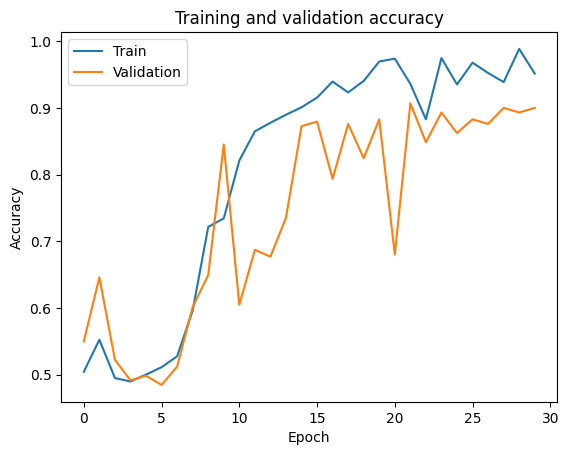


Precision avec des donnée des validation differente et augmentation de donnée , 50 epochs:


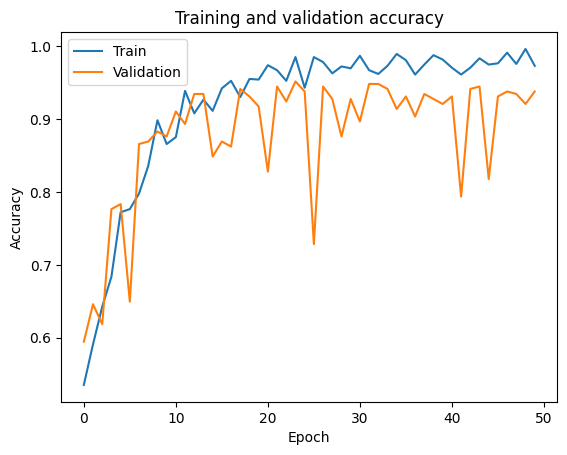

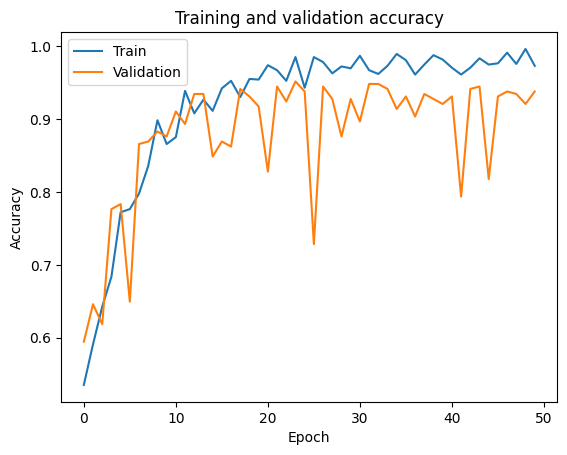

In [24]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

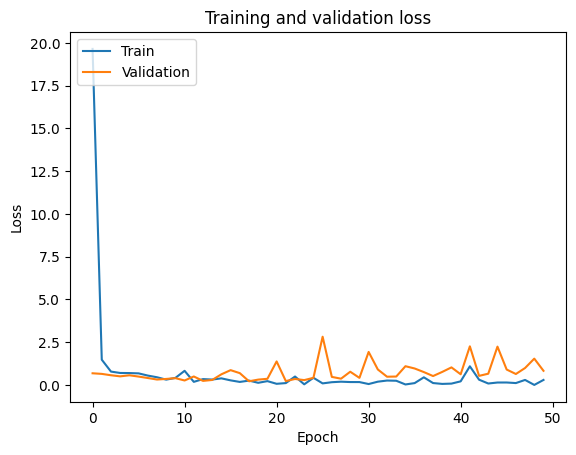

In [20]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
# test model
import numpy as np
from PIL import Image
def predict_class(fichier):
    #import image
    image=plt.imread(fichier)
    plot_image(image)
    #preprocess image
    image=np.array(image)
    image=image.astype("float32")/255
    #predict
    img_size = 150
    inference=model.predict((tf.expand_dims(tf.image.resize(image,(img_size,img_size)),axis=0)))
    predicted_class_indices = np.round(inference)
    return (predicted_class_indices)

def toText(c):
    if c[0][0] == 1:
        return "Asterix"
    else :
        return "Obelix"